# Part 0: Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod, CarliniL2Method , ProjectedGradientDescentTensorFlowV2, AutoProjectedGradientDescent,ProjectedGradientDescent

print(tf.__version__)

2025-10-10 14:31:45.051343: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-10 14:31:45.051710: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-10 14:31:45.111018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-10 14:31:46.866090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

2.20.0


# Part 1 : Building a Model

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 # Normalize

category_loss_from_logits = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(10, activation='linear')
])

model.compile(optimizer='adam',
              loss=category_loss_from_logits,
              metrics=['accuracy']);

E0000 00:00:1760099508.418000   28158 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1760099508.424027   28158 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
model.fit(x_train, y_train, epochs=5);

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9143 - loss: 0.2981
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9572 - loss: 0.1443
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9684 - loss: 0.1058
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9732 - loss: 0.0872
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9764 - loss: 0.0743


In [5]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.9767 - loss: 0.0741
Accuracy on test data: 97.67%


In [6]:
#1/ Train for 5 epochs a model called "model1" that has only one hidden layer of 64 neurons and only *linear* activations instead of ReLU;
#compare its accuracy with the first model


model1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='linear'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(10, activation='linear')
])

model1.compile(optimizer='adam',
              loss=category_loss_from_logits,
              metrics=['accuracy']);

model1.fit(x_train,y_train, epochs=5);


loss_test, accuracy_test = model1.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 846us/step - accuracy: 0.8842 - loss: 0.4036
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 817us/step - accuracy: 0.9089 - loss: 0.3210
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 859us/step - accuracy: 0.9130 - loss: 0.3083
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 838us/step - accuracy: 0.9147 - loss: 0.3004
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 818us/step - accuracy: 0.9171 - loss: 0.2969
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.9235 - loss: 0.2796
Accuracy on test data: 92.35%


In [7]:
#2/ Train for 5 epochs a model called "model2" that has 5 dense layer of 128 neurons and a relu activation and no dropout; compare its accuracy with the first model

model2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(10, activation='linear')
])

model2.compile(optimizer='adam',
              loss=category_loss_from_logits,
              metrics=['accuracy']);

model2.fit(x_train, y_train, epochs=5);
loss_test, accuracy_test = model2.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9249 - loss: 0.2475
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9663 - loss: 0.1143
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9746 - loss: 0.0852
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9786 - loss: 0.0698
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9827 - loss: 0.0581
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.9748 - loss: 0.1011
Accuracy on test data: 97.48%


In [8]:
#2bis/ (OPTIONAL CHALLENGE /!\) Train for 5 epochs a "model3" that obtains more 99% of accuracy on *test* data (hint: you might want to use 2D convolutional layers,i.e. tf.keras.layers.Conv2D(...), and MaxPool layers, i.e.  tf.keras.layers.MaxPooling2D(...))
X_train, Y_train = np.reshape(x_train, (*x_train.shape, 1)), np.reshape(y_train, (*y_train.shape, 1))
X_test, Y_test = np.reshape(x_test, (*x_test.shape, 1)), np.reshape(y_test, (*y_test.shape, 1))

model3 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128,  activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(10, activation='linear')
])

model3.compile(optimizer='adam',
            loss=category_loss_from_logits,
            metrics=['accuracy']);

model3.fit(X_train, Y_train, epochs=5)
loss_test, accuracy_test = model3.evaluate(X_test, Y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9609 - loss: 0.1275
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9865 - loss: 0.0440
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9900 - loss: 0.0309
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9925 - loss: 0.0229
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9945 - loss: 0.0161
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9916 - loss: 0.0254
Accuracy on test data: 99.16%


# Part 2: Simple Whitebox Adversarial Attacks

In [9]:
classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=True, )
x_test = x_test[0:100]
y_test = y_test[0:100]

## FGSM attacks

In [10]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=16/255, norm=np.inf)

In [11]:
x_test_adv = attack_fgsm.generate(x_test)

# from matplotlib import pyplot as plt
# fig, axs = plt.subplots(1,2)

# i = 2
# axs[0].imshow(x_test[i], interpolation='nearest')
# axs[1].imshow(x_test_adv[i], interpolation='nearest')
# plt.show()

In [12]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))

print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5500 - loss: 1.2375 
Accuracy on adversarial test data: 55.00%
Average perturbation: 0.04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
predicted class of original image: 7


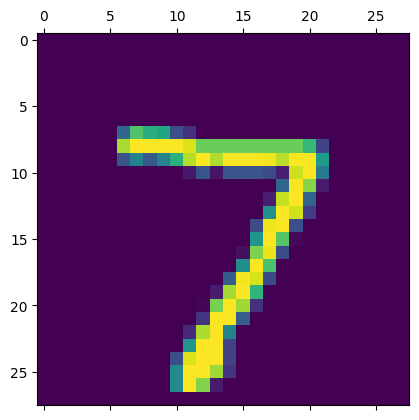

In [13]:
y_pred_0 = model.predict(x_test[0:1])
print(f"predicted class of original image: {y_pred_0.argmax()}")
plt.matshow(x_test[0])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted class of adversarial attack: 7


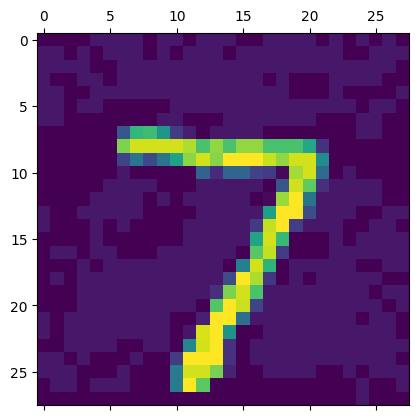

In [14]:
y_pred_0 = model.predict(x_test_adv[0:1])
print(f"predicted class of adversarial attack: {y_pred_0.argmax()}")
plt.matshow(x_test_adv[0])
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9600 - loss: 0.0768 
Accuracy on adversarial test data: 96.00%
Average perturbation: 0.00956
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted class of adversarial attack: 7


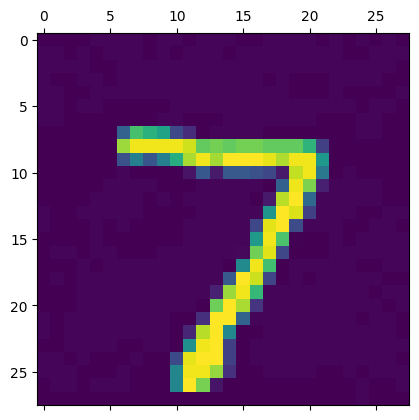

In [15]:
#3/ Run an FGSM attack on the norm Inf and 2 with EQUIVALENT epsilons, e.g. eps=4/255 for the norm Inf and eps=(16/255)*sqrt(784) for the l2 norm. Display the results. Which one leads to the best image?

attack_fgsm = FastGradientMethod(
    estimator=classifier,
    eps=4/255,
    norm=np.inf
)
x_test_adv = attack_fgsm.generate(x_test)

loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))

print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.5f}'.format(perturbation))
y_pred_0 = model.predict(x_test_adv[0:1])
print(f"predicted class of adversarial attack: {y_pred_0.argmax()}")
plt.matshow(x_test_adv[0])
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2500 - loss: 2.9203 
Accuracy on adversarial test data: 25.00%
Average perturbation: 0.02962
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted class of adversarial attack: 3


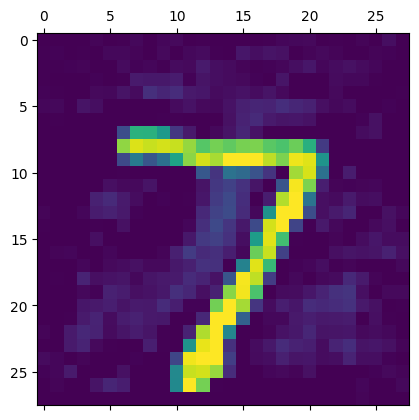

In [16]:
#3/ Run an FGSM attack on the norm Inf and 2 with EQUIVALENT epsilons, e.g. eps=16/255 for the norm Inf and eps=(16/255)*sqrt(784) for the l2 norm. Display the results. Which one leads to the best image?

attack_fgsm = FastGradientMethod(
    estimator=classifier,
    eps=16 / 255 * 784**0.5,
    norm=2,
)
x_test_adv = attack_fgsm.generate(x_test)

loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))

print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.5f}'.format(perturbation))
y_pred_0 = model.predict(x_test_adv[0:1])
print(f"predicted class of adversarial attack: {y_pred_0.argmax()}")
plt.matshow(x_test_adv[0])
plt.show()

# Part 3: Other Adversarial Attacks (Carlini-Wagner, APGD...)

In [17]:
attack_cw = CarliniL2Method(classifier=classifier,
                              max_iter=20,
                              learning_rate=0.01,
                              initial_const=1e0,
                              )

In [ ]:
x_test_adv_cw = attack_cw.generate(x_test[:10])

C&W L_2:   0%|          | 0/10 [00:00<?, ?it/s]

C&W L_2: 100%|██████████| 10/10 [05:09<00:00, 30.91s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: 7
L2 dist to original image 0.78


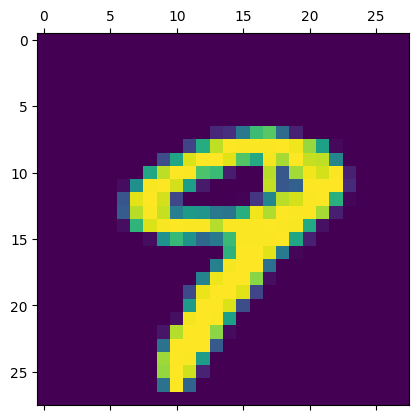

In [19]:
idx = 9
plt.matshow(x_test_adv_cw[idx])
y_pred_adv_cw = model.predict(x_test_adv_cw[idx:idx+1])
print(f"Predicted class: {y_pred_adv_cw.argmax()}")
print(f"L2 dist to original image {np.linalg.norm(x_test_adv_cw[idx] - x_test[idx],):.2f}")
plt.show()

In [20]:
loss_test, accuracy_test = model.evaluate(x_test_adv_cw, y_test[:10])
perturbation = np.mean(np.abs((x_test_adv_cw - x_test[:10])))
l_2_perturbation = np.linalg.norm(x_test_adv_cw - x_test[:10],axis=(1,2),)
l_2_perturbation_mean_cw = np.mean(l_2_perturbation)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
print('Average l2 perturbation: {:4.2f}'.format(l_2_perturbation_mean_cw))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 0.8718
Accuracy on adversarial test data: 0.00%
Average perturbation: 0.02
Average l2 perturbation: 2.56


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 78.6019 
Accuracy on adversarial test data: 0.00%
Average perturbation: 0.02
Average l2 perturbation: 20.30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class: 2
L2 dist to original image 20.86


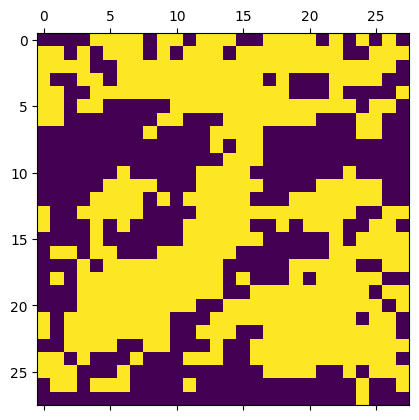

In [21]:
#4/ Generate a new FGSM attack with the same l2 perturbation as the previous CW and compare their effectiveness: i.e. %of success for similar average l2 perturbation

eps= l_2_perturbation_mean_cw
attack_fgsm = FastGradientMethod(
    estimator=classifier,
    eps=16 / 255 * 784**0.5,
)
x_test_adv = attack_fgsm.generate(x_test)

loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)


l_2_perturbation = np.linalg.norm(x_test_adv - x_test,axis=(1,2))
l_2_perturbation_mean = np.mean(l_2_perturbation)


print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
print('Average l2 perturbation: {:4.2f}'.format(l_2_perturbation_mean))

idx = 0
plt.matshow(x_test_adv[idx])
y_pred_adv = model.predict(x_test_adv[idx:idx+1])
print(f"Predicted class: {y_pred_adv.argmax()}")
print(f"L2 dist to original image {np.linalg.norm(x_test_adv[idx] - x_test[idx],):.2f}")
plt.show()

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]





































































































































































































































































AutoPGD - restart:  20%|██        | 1/5 [00:33<02:12, 33.16s/it]















AutoPGD - restart:  40%|████      | 2/5 [00:34<00:43, 14.61s/it]















AutoPGD - restart:  60%|██████    | 3/5 [00:36<00:17,  8.65s/it]















AutoPGD - restart:  80%|████████  | 4/5 [00:37<00:05,  5.85s/it]















AutoPGD - restart: 100%|██████████| 5/5 [00:39<00:00,  7.89s/it]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0312 - loss: 8.4966

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0200 - loss: 8.2797 
1.7568622031940173
Accuracy on adversarial test data: 2.00%
Average perturbation: 0.02
Average l2 perturbation: 1.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class: 3
L2 dist to original image 1.76


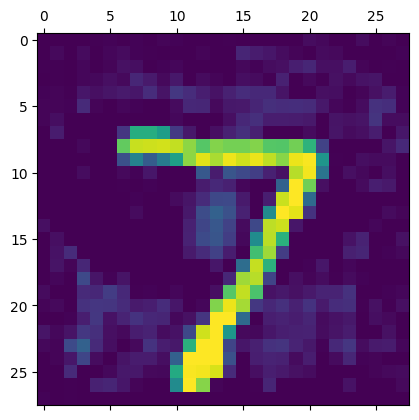

In [22]:
#5/ Generate a new APGD attack (class AutoProjectedGradientDescent) with the same (or lower) average l2 perturbation as the previous CW and FGSM, and compare their effectiveness
# to limit computation time you can set 'max_iter=10' and "nb_random_init=1", in the function arguments
eps= l_2_perturbation_mean_cw

attack_apgd = AutoProjectedGradientDescent(
    estimator=classifier,
    eps=16 / 255 * 784**0.5,
    norm=2,
)
x_test_adv_apgd = attack_apgd.generate(x_test)

loss_test, accuracy_test = model.evaluate(x_test_adv_apgd, y_test)


l_2_perturbation = np.linalg.norm(x_test_adv_apgd - x_test,axis=(1,2))
l_2_perturbation_mean = np.mean(l_2_perturbation)
print(l_2_perturbation_mean)

print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
print('Average l2 perturbation: {:4.2f}'.format(l_2_perturbation_mean))
idx = 0
plt.matshow(x_test_adv_apgd[idx])
y_pred_adv_apgd = model.predict(x_test_adv_apgd[idx:idx+1])
print(f"Predicted class: {y_pred_adv_apgd.argmax()}")
print(f"L2 dist to original image {np.linalg.norm(x_test_adv_apgd[idx] - x_test[idx],):.2f}")
plt.show()

PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 15.5789 
2.5600494438235533
Accuracy on adversarial test data: 0.00%
Average perturbation: 0.02
Average l2 perturbation: 2.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: 3
L2 dist to original image 1.76


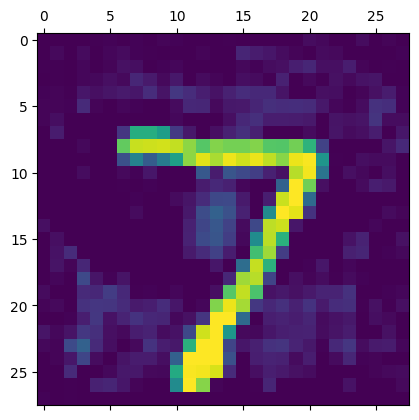

In [23]:
# 5bis/ /!\ OPTIONAL CHALLENGE: find an adversarial attack in the same library (https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html)
#having better results with the SAME l2 perturbation
from art.attacks.evasion import ProjectedGradientDescent
eps= l_2_perturbation_mean_cw
attack_projected = ProjectedGradientDescent(
    estimator=classifier,
    eps=eps, 
    norm=2,
)

x_test_adv_projected = attack_projected.generate(x_test)

loss_test, accuracy_test = model.evaluate(x_test_adv_projected, y_test)


l_2_perturbation = np.linalg.norm(x_test_adv_projected - x_test,axis=(1,2))
l_2_perturbation_mean = np.mean(l_2_perturbation)
print(l_2_perturbation_mean)

print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
print('Average l2 perturbation: {:4.2f}'.format(l_2_perturbation_mean))
idx = 0
plt.matshow(x_test_adv_apgd[idx])
y_pred_adv_apgd = model.predict(x_test_adv_apgd[idx:idx+1])
print(f"Predicted class: {y_pred_adv_apgd.argmax()}")
print(f"L2 dist to original image {np.linalg.norm(x_test_adv_apgd[idx] - x_test[idx],):.2f}")
plt.show()

# Part 4: Transfer attacks

In [24]:
classifier_source = KerasClassifier(model=model2, clip_values=(0, 1))
classifier_target = KerasClassifier(model=model, clip_values=(0, 1))

attack_fgsm = FastGradientMethod(estimator=classifier_source, eps=16/255, norm=np.inf)

In [25]:
x_transfer_adv = attack_fgsm.generate(x_test)

In [26]:
perturbation = np.mean(np.abs((x_transfer_adv - x_test)))
loss_source, accuracy_source = model2.evaluate(x_transfer_adv, y_test)
loss_target, accuracy_target = model.evaluate(x_transfer_adv, y_test)

print('Average perturbation: {:4.2f}'.format(perturbation))
print('Accuracy on adversarial test data for source model: {:4.2f}%'.format(accuracy_source * 100))
print('Accuracy on adversarial test data for target model: {:4.2f}%'.format(accuracy_target * 100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5100 - loss: 1.8719 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8600 - loss: 0.4137 
Average perturbation: 0.04
Accuracy on adversarial test data for source model: 51.00%
Accuracy on adversarial test data for target model: 86.00%


In [27]:
#6/ Compare the transferability of the attack when using the norm 2 and eps=0.3
attack_fgsm = FastGradientMethod(estimator=classifier_source, eps=0.3, norm=2)

x_transfer_adv = attack_fgsm.generate(x_test)

In [28]:
perturbation = np.mean(np.abs((x_transfer_adv - x_test)))
loss_source, accuracy_source = model2.evaluate(x_transfer_adv, y_test)
loss_target, accuracy_target = model.evaluate(x_transfer_adv, y_test)

print('Average perturbation: {:4.2f}'.format(perturbation))
print('Accuracy on adversarial test data for source model: {:4.2f}%'.format(accuracy_source * 100))
print('Accuracy on adversarial test data for target model: {:4.2f}%'.format(accuracy_target * 100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9600 - loss: 0.1231 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0373 
Average perturbation: 0.01
Accuracy on adversarial test data for source model: 96.00%
Accuracy on adversarial test data for target model: 100.00%


# Part 5: Adversarial Attack defenses

## Adversarial training

In [29]:
from art import config
from keras.models import load_model
from art.utils import get_file, load_dataset

(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')


In [30]:
path = get_file('mnist_cnn_original.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/p2nyzne9chcerid/mnist_cnn_original.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False)

In [31]:
classifier_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,036 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [32]:
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))

print("Original test data:")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(len(x_test)-nb_correct_pred))
print("Accuracy: {}".format(nb_correct_pred/len(x_test)*100))

Original test data:
Correctly classified: 9842
Incorrectly classified: 158
Accuracy: 98.42


In [33]:
attacker = FastGradientMethod(classifier, eps=0.5)
x_test_adv = attacker.generate(x_test, y_test)

In [34]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test, axis=1))

print("Adversarial test data:")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(len(x_test_adv)-nb_correct_adv_pred))
print("Accuracy: {}".format(nb_correct_adv_pred/len(x_test_adv)*100))

Adversarial test data:
Correctly classified: 31
Incorrectly classified: 9969
Accuracy: 0.31


In [35]:
path = get_file('mnist_cnn_robust.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False)

In [36]:
robust_classifier_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,639,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,668,492 (6.36 MB)

 Trainable params: 1,668,490 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [37]:
x_test_robust_pred = np.argmax(robust_classifier.predict(x_test), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test, axis=1))

print("Original test data:")
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(len(x_test)-nb_correct_robust_pred))
print("Accuracy: {}".format(nb_correct_robust_pred/len(x_test)*100))

Original test data:
Correctly classified: 9736
Incorrectly classified: 264
Accuracy: 97.36


In [38]:
attacker_robust = FastGradientMethod(robust_classifier, eps=0.5)
x_test_adv_robust = attacker_robust.generate(x_test, y_test)

In [39]:
x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test, axis=1))

print("Adversarial test data:")
print("Correctly classified: {}".format(nb_correct_adv_robust_pred))
print("Incorrectly classified: {}".format(len(x_test_adv_robust)-nb_correct_adv_robust_pred))
print("Accuracy: {}".format(nb_correct_adv_robust_pred/len(x_test_adv_robust)*100))

Adversarial test data:
Correctly classified: 1383
Incorrectly classified: 8617
Accuracy: 13.83


### Against stronger attacks: PGD

In [46]:
from art.attacks.evasion import ProjectedGradientDescent
attacker_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.5, eps_step=0.01, max_iter=100, verbose=False)
attacker_robust_pgd = ProjectedGradientDescent(estimator=robust_classifier, eps=0.5, eps_step=0.01, max_iter=100, verbose=False)

In [47]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
eps_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nb_correct_original = []
nb_correct_robust = []

nb_samples = 100

for eps in eps_range:
    print("Running eps {}".format(eps))
    attacker_pgd.set_params(**{'eps': eps})
    attacker_robust_pgd.set_params(**{'eps': eps})
    x_test_adv = attacker_pgd.generate(x_test[:nb_samples], y_test[:nb_samples])
    x_test_adv_robust = attacker_robust_pgd.generate(x_test[:nb_samples], y_test[:nb_samples])

    x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test[:nb_samples], axis=1)) / nb_samples]

    x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test[:nb_samples], axis=1)) / nb_samples]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred / 10000] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred / 10000] + nb_correct_robust



Running eps 0.05
Running eps 0.1
Running eps 0.2
Running eps 0.3
Running eps 0.4
Running eps 0.5
Running eps 0.6


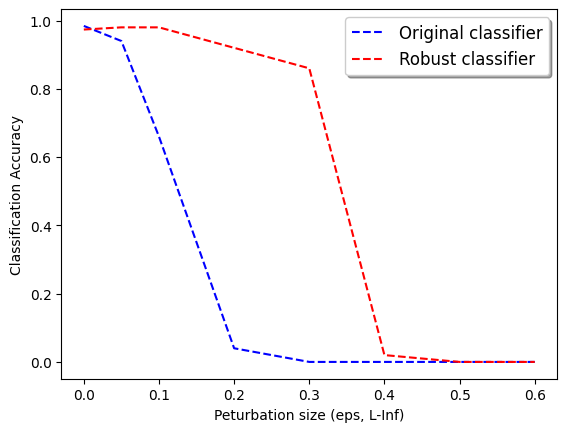

In [48]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper right', shadow=True, fontsize='large')

plt.xlabel('Peturbation size (eps, L-Inf)')
plt.ylabel('Classification Accuracy')
plt.show()

Running eps 0.05
Running eps 0.1
Running eps 0.2
Running eps 0.3
Running eps 0.4
Running eps 0.5
Running eps 0.6


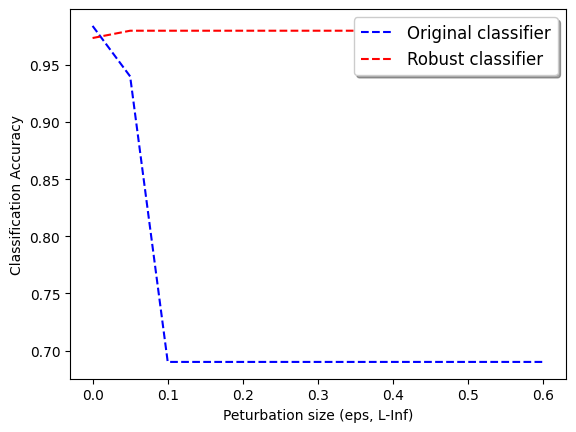

In [49]:
#8/ What happens when we reduce the number of max_iter to 10 ? Which model becomes better?
attacker_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.5, eps_step=0.01, max_iter=10, verbose=False)
attacker_robust_pgd = ProjectedGradientDescent(estimator=robust_classifier, eps=0.5, eps_step=0.01, max_iter=10, verbose=False)

eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
eps_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nb_correct_original = []
nb_correct_robust = []

nb_samples = 100

for eps in eps_range:
    print("Running eps {}".format(eps))
    attacker_pgd.set_params(**{'eps': eps})
    attacker_robust_pgd.set_params(**{'eps': eps})
    x_test_adv = attacker_pgd.generate(x_test[:nb_samples], y_test[:nb_samples])
    x_test_adv_robust = attacker_robust_pgd.generate(x_test[:nb_samples], y_test[:nb_samples])

    x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test[:nb_samples], axis=1)) / nb_samples]

    x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test[:nb_samples], axis=1)) / nb_samples]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred / 10000] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred / 10000] + nb_correct_robust

fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper right', shadow=True, fontsize='large')

plt.xlabel('Peturbation size (eps, L-Inf)')
plt.ylabel('Classification Accuracy')
plt.show()



1.   List item
2.   List item

